# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных и алгоритм выполнения

### Признаки

* `DateCrawled` — дата скачивания анкеты из базы
*	`VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

Целевой признак

`Price` — цена (евро)


### Основные шаги

1.	Загрузите данные: файл `autos.csv`.
2.	Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3.	Подготовьте выборки для обучения моделей.
4.	Обучите разные модели, одна из которых — LightGBM. Для каждой модели попробуйте разные гиперпараметры.
5.	Проанализируйте время обучения, время предсказания и качество моделей.
6.	Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

### Примечания

* Для оценки качества моделей применяйте метрику `RMSE`.
* Значение метрики `RMSE` должно быть меньше 1600.

In [ ]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/455.5 kB ? eta -:--:--
   - ------------------------------------- 20.5/455.5 kB 682.7 kB/s eta 0:00:01
   -------- ------------------------------- 102.4/455.5 kB 1.2 MB/s eta 0:00:01
   ------------------ --------------------- 215.0/455.5 kB 1.6 MB/s eta 0:00:01
   --------------------------- ------------ 317.4/455.5 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 455.5/455.5 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Подготовка данных

In [ ]:
# Загрузим необходимые библиотеки и инструменты
import math
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
#from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn import tree

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection

from sklearn.utils import shuffle
from mlxtend.plotting import plot_decision_regions
from itertools import combinations


import warnings
warnings.filterwarnings('ignore')


RANDOM_STATE = 123456

In [ ]:
df = pd.read_csv('autos.csv')


In [ ]:
# Первые 5 строк методом head()
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
# Общая информация о данных методом info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Датасет содержит 354369 записей о продажах автомобилей. Имеются пропущенные значения

Типы переменных соответствуют типам содержащихся в них данных. Столбцы `DateCrawled`, `DateCreated` и `LastSeen` необходимо перевести в тип даты.

In [ ]:
df['DateCrawled']= pd.to_datetime(df['DateCrawled'])
df['DateCreated']= pd.to_datetime(df['DateCreated'])
df['LastSeen']= pd.to_datetime(df['LastSeen'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [ ]:
# Проверим наличие дубликатов методом duplicated()
df.duplicated().sum()

4

Датасет содержит 4 дублирующие записи, их можно удалить.

Для удаления дубликатов используем метод `drop_duplicates()`

In [ ]:
df=df.drop_duplicates().reset_index(drop=True)

In [ ]:
# Проверим наличие пропущенных значений
df.isnull().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
NotRepaired          0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Примерно по 5,5% записей о моделе автомобиля и типе коробки передач отсуствуют. Примерно 10,5% записей о типе кузова тоже отсутствует. Заполнить эти пропуски не представляется возможным, т.к. нет никаких дополнительных сведений о продаваемом автомобиле. Автомобиль одной и то же марки может быть представлен в разной комплектации и иметь различный тип кузова и использовать различные виды топлива.

Попробуем восстановить по возможности данные. Изучим распределения признаков и оценим типичные значения для возможного заполнения.

В первую очередь на пропуски можно посмотреть с помощью столбчатой диаграммы (функция `msno.bar()`).

<Axes: >

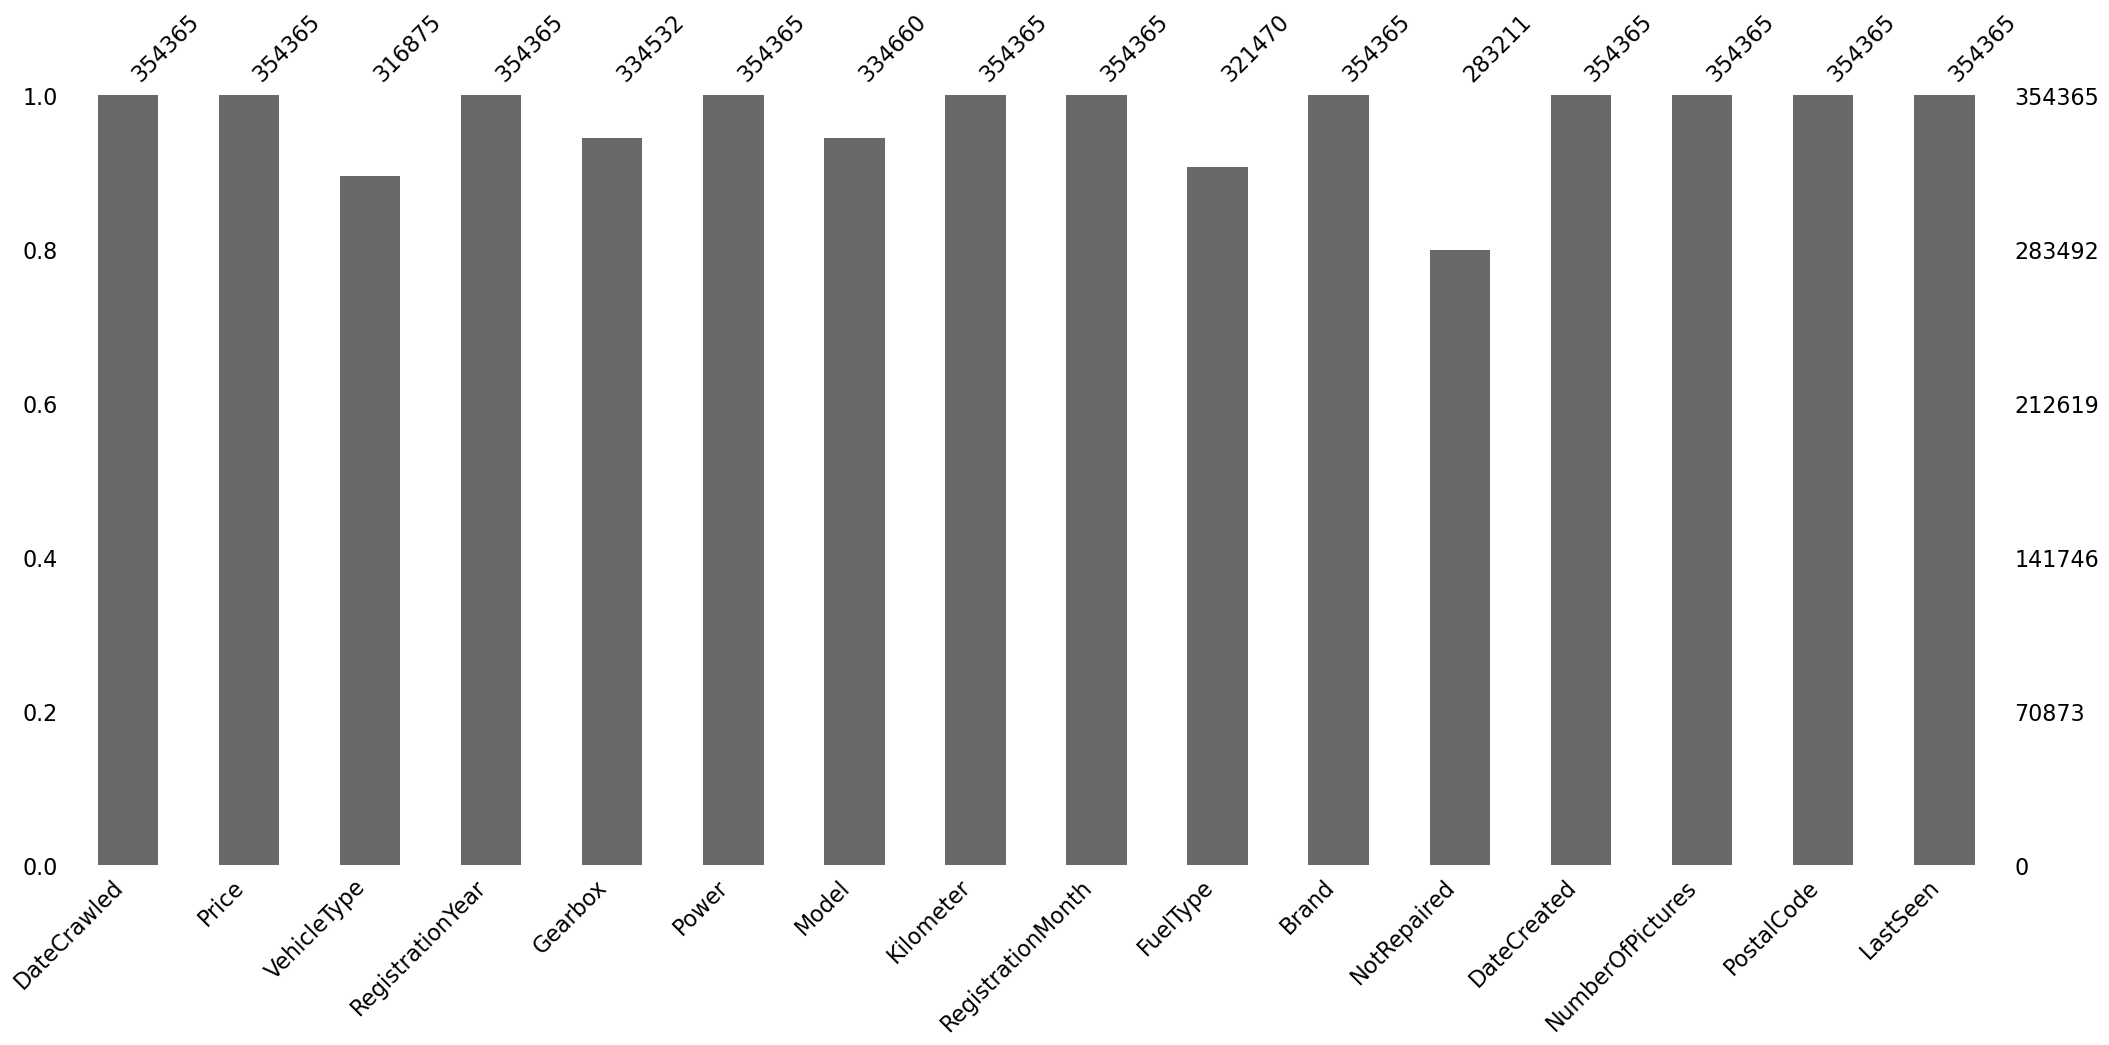

In [ ]:
msno.bar(df)

На этом графике мы четко видим процент (слева) и абсолютное количество (справа и сверху) заполненных значений. При этом столбчатая диаграмма не дает информации о том, где именно больше всего пропущенных значений. Другими словами, есть ли в пропусках какая-то закономерность или нет.

Для этого подойдет матрица пропущенных значений (функция `msno.matrix()`)

<Axes: >

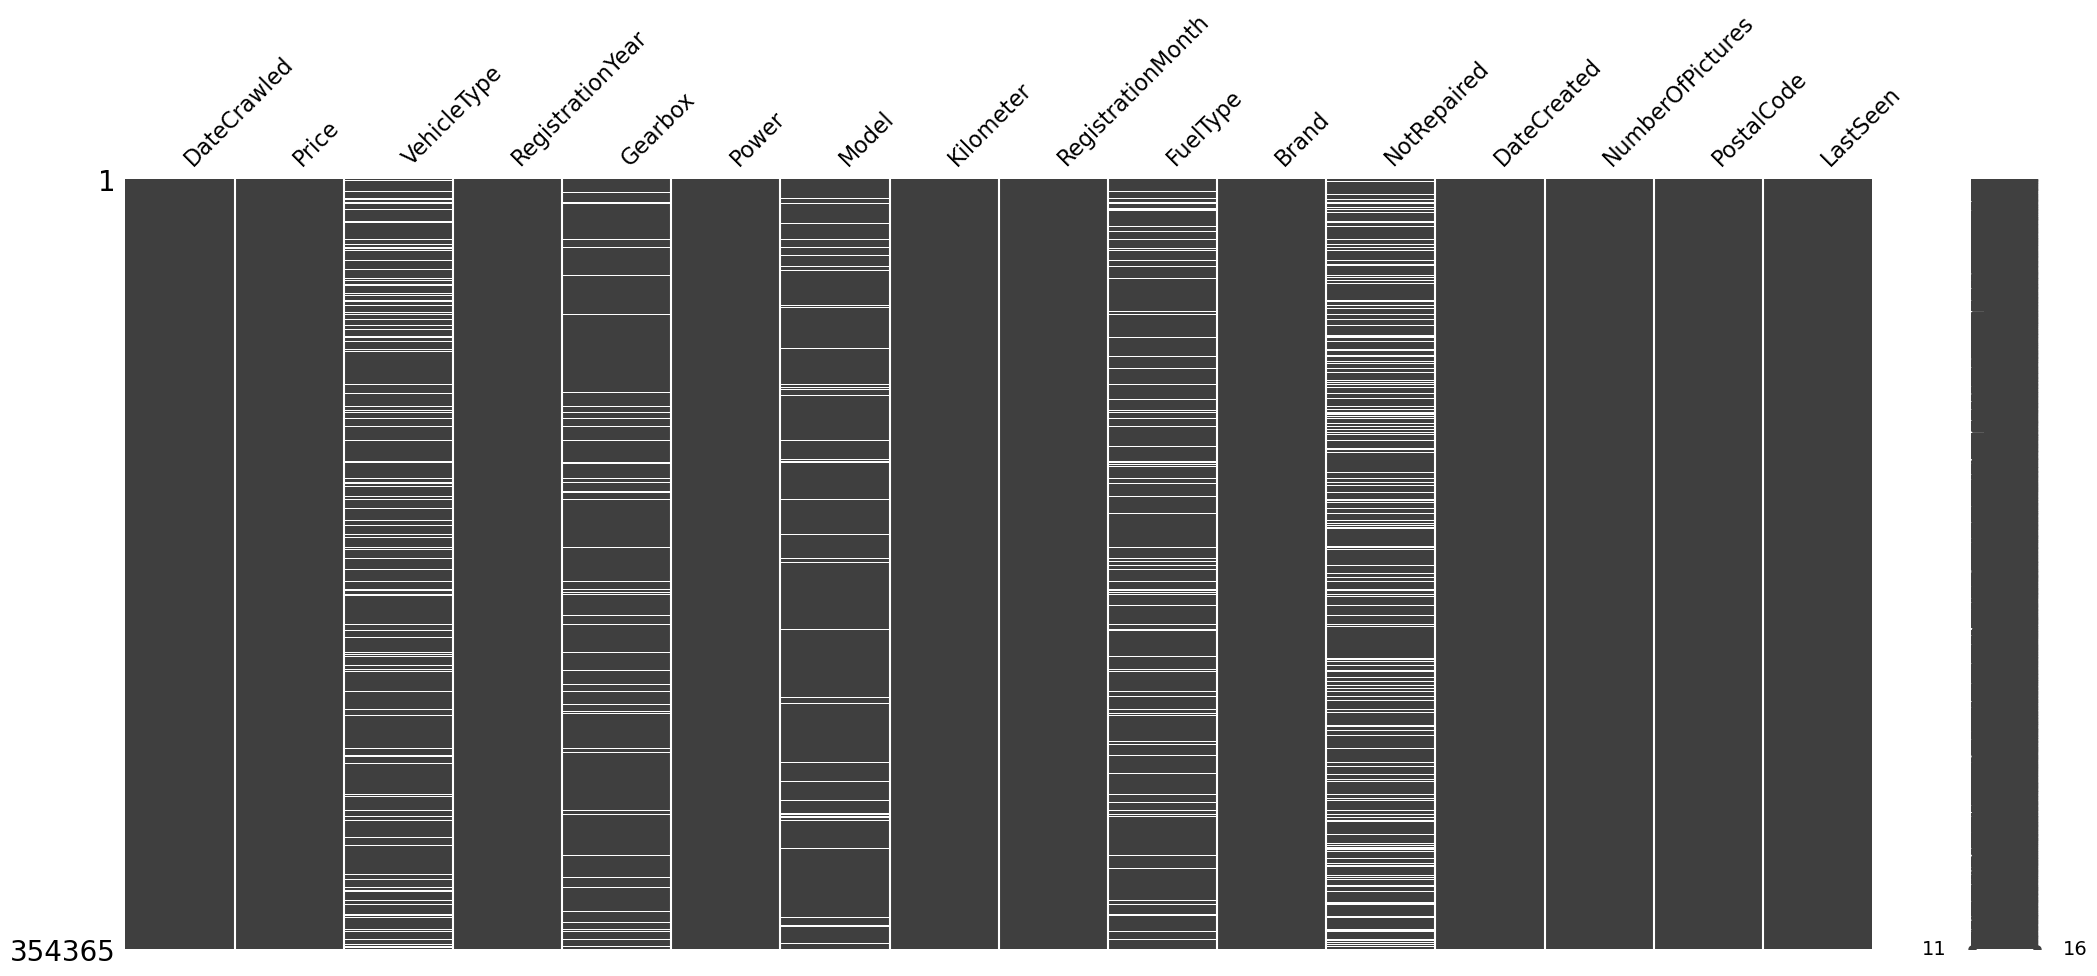

In [ ]:
msno.matrix(df)

Распределение пропущенных значений в датасете выглядит случайным, закономерностью были бы пропуски, например, только в первой половине наблюдений.

Еще один интересный инструмент — матрица корреляции пропущенных значений (`nullity correlation matrix`).

По сути, она показывает насколько сильно присутствие или отсутствие значений одного признака влияет на присутствие значений другого.

Если мы знаем, в каких столбцах есть пропуски, то можем просто последовательно применить к ним методы `.isnull()` и `.corr()`. Т.к. пропуски есть во всех столбцах, то рассмотрим матрицу корреляций пропусков по всем данным.

In [ ]:
#nullity correlation matrix
df[['VehicleType','Gearbox','Model','FuelType','NotRepaired']].isnull().corr()

,VehicleType,Gearbox,Model,FuelType,NotRepaired
VehicleType,1.000000,0.314202,0.189907,0.436778,0.298731
Gearbox,0.314202,1.000000,0.162228,0.299482,0.269864
Model,0.189907,0.162228,1.000000,0.226342,0.156694
FuelType,0.436778,0.299482,0.226342,1.000000,0.242166
NotRepaired,0.298731,0.269864,0.156694,0.242166,1.000000


Визуально, корреляцию пропущенных значений можно представить с помощью тепловой карты (`heatmap`). Для этого есть функция `msno.heatmap()`.

ValueError: could not convert string to float: '--'

<Figure size 800x600 with 0 Axes>

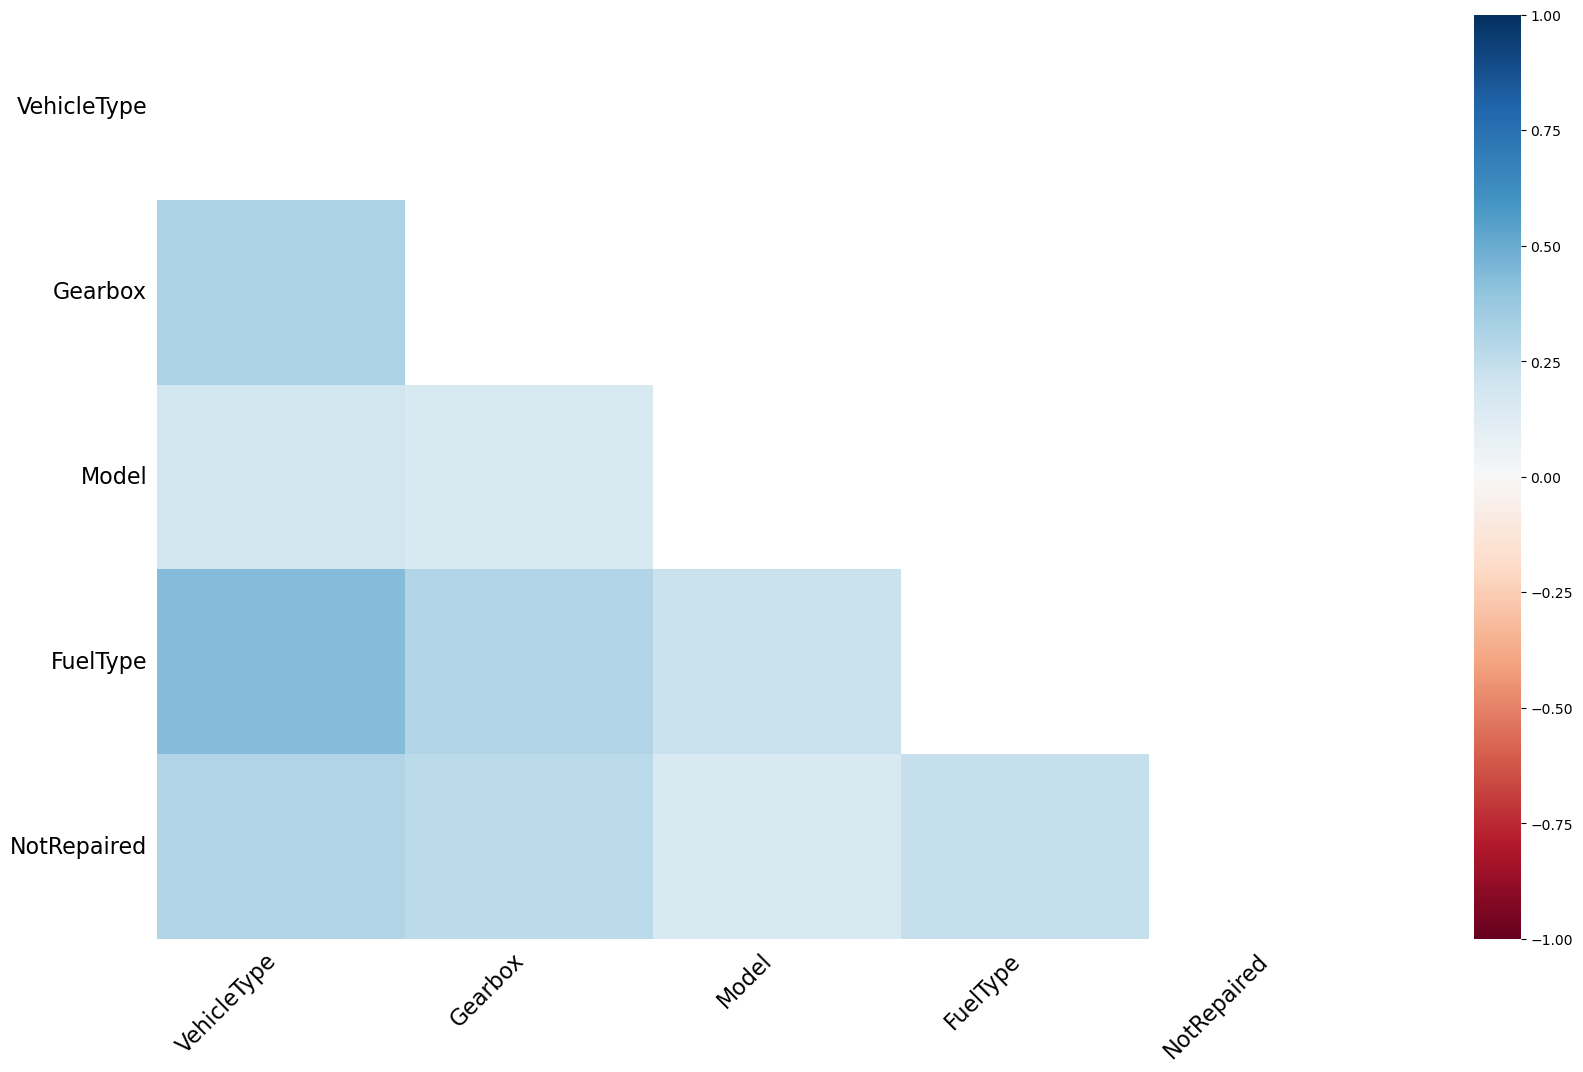

In [ ]:
plt.figure(figsize= (8,6))
msno.heatmap(df);

plt.show()

Мы видим, что корреляция пропусков меньше 0.5 для пропусков всех признаков. Другими словами, пропуски одного признака не влияют на пропуски другого.

In [ ]:
# Оценим количество различных моделей автомобилей
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [ ]:
# Рассмотрим распределение моделей автомобилей методом value_counts()
df['Model'].value_counts()

Model
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

Среди представленных автомобилей 250 различных моделей и 24420 объявлений, в которых модель продаваемого автомобиля указана как `other`. Заменим пропуски в столбце `Model` на значение `other`.

In [ ]:
df[['Model']] = df[['Model']].fillna('other')

В столбцах `VehicleType`, `Gearbox` и `FuelType` пропущенные значения заполним наиболее часто встречающимся значением в соответствии с представленной моделью.

In [ ]:
df['VehicleType'].fillna(df.groupby('Model')['VehicleType'].transform(lambda x: x.value_counts().idxmax()), inplace=True)
df['Gearbox'].fillna(df.groupby('Model')['Gearbox'].transform(lambda x: x.value_counts().idxmax()), inplace=True)
df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()), inplace=True)

In [ ]:
# В столбце 'NotRepaired' содержится около 20% пропущенных значений.
# Оценим их количество в каждой категории методом value_counts()
df['NotRepaired'].value_counts()


NotRepaired
no     247158
yes     36053
Name: count, dtype: int64

Преобладают значения `no`. Скорее всего, если владелец не указал в объявлении, был ли автомобиль в ремонте, то либо считает этот ремонт незначительным (типа ТО проходил), либо не хочет афишировать эту информацию, чтобы не снижать цену на автомобиль. Поэтому будем предполагать в этой ситуации, что автомобиль был в ремонте и заполним пропущенные значения категорией `unknown`.

In [ ]:
df[['NotRepaired']] = df[['NotRepaired']]. fillna('unknown')

In [ ]:
# Проверим количество пропусков в датасете
df.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [ ]:
# Изучим числовые характеристики данных методом describe()
df.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365,354365.0,354365.000000,354365
mean,2016-03-21 12:58:09.520460544,4416.679830,2004.234481,110.093816,128211.363989,5.714650,2016-03-20 19:12:06.583042560,0.0,50508.503800,2016-03-29 23:51:06.766184960
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:52
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.176349,90.228466,189.851330,37905.083858,3.726432,NaN,0.0,25783.100078,NaN


Согласно полученным значениям, видим некоторые нетипичные значения. Минимальное значение цены автомобиля и мощность двигателя равны нулю, чего не может быть в действительности. Также минимальный год регистрации автомобиля 1000 вызывает подозрения и максимальный год регистрации равен 9999.

Выясним, сколько около-нулевых значений цены присутствует в датасете (не больше 500 евро).

In [ ]:
len(df[df['Price']<=500])/len(df)

0.11774300509361817

Низкие значения целевого признака составляют около 12% данных. Попробуем заполнить их медианным значением для каждой модели.

In [ ]:
# Сгруппируем данные по модели и вычислим медианную цену для каждой модели автомобиля
model_median_price =df.groupby(['Model'])['Price'].median()
print('Медианы цены по каждой модели: ')
print(model_median_price)

Медианы цены по каждой модели: 
Model
100         1190.0
145          599.0
147         1990.0
156         1200.0
159         6400.0
            ...   
yaris       3250.0
yeti       12945.0
ypsilon      900.0
z_reihe     9800.0
zafira      2899.0
Name: Price, Length: 250, dtype: float64


In [ ]:
# Функция для присваивания значения медианы
def med_insert(model_price):
    if model_price not in model_median_price:
        return np.nan
    return model_median_price[model_price]

In [ ]:
df.loc[df['Price']<= 500, 'Price'] = df['Model'].apply(med_insert)
k=len(df[df['Price']<=500])
#Проверим количество оставшихся пропусков
print('Количество около-нулевых значений цены равно ',k )

Количество около-нулевых значений цены равно  39


Осталось всего 39 записей, для которых нет соответствующей модели. Поэтому оставшиеся 39 записей с ценой ниже 500 евро удалим.

In [ ]:
df = df[df.Price > 501]

In [ ]:
len(df[df['Price']<=500])

0

In [ ]:
#Оценим уникальные записи значений мощности двигателя
df['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

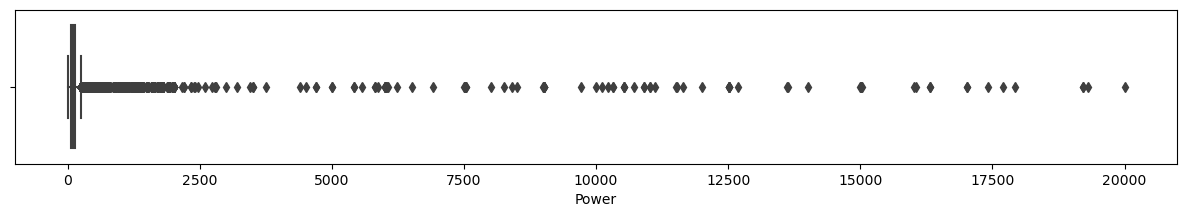

In [ ]:
# Изобразим диаграмму ящик с усами для обнаружения выбросов
plt.figure(figsize=(15,2))
sns.boxplot(x=df['Power'])

plt.show()

Согласно данным из интернета (https://atlanticexpress.com.ua/samye-moshhnye-serijnye-avto-v-mire-ot-1750-l-s/), самые мощные автомобили имеют мощность двигателя до 2000 л.с., поэтому указанные мощности являются ошибочными.

Автомобили с мощностью двигателя менее 20 л.с. существуют (https://www.drom.ru/catalog/volkswagen/kaefer/specs/engine_capacity/), поэтому оценим количество записей, для которых мощность двигателя равна 0 или составляет более 2000 л.с.



In [ ]:
# Количество записей, для которых мощность двигателя более 2000 л.с.
len(df[df['Power']>2000])/len(df)

0.0003386749905453232

Таких значений менее 1%, поэтому удалим их из датасета.

Оценим количество записей, в которых мощность двигателя равна 0

In [ ]:
len(df[df['Power']<20])/len(df)

0.11465559575753129

Нулевых значений мощности около 11%, удаление приведет к потере данных. Возможно, нулевые значения соответствуют ситуации, когда двигатель в автомобиле отсутствует. Возможно, люди продают автомобиль без двигателя. Поэтому все нулевые значения мощности двигателя оставим.

In [ ]:
# Удалим записи, для которых мощность двигателя больше 2000 л.с.
df = df[df.Power < 2000]

Первый автомобиль появился в 1886 году, поэтому годом регистрации автомобиля не может быть число, меньшее 1886. Сейчас идет 2024 год, поэтому год регистрации автомобиля не должен превышать 2024 года.

Определим максимальную дату скачивания анкеты из базы `DateCreated` и сравним ее с максимальной датой регистрации автомобиля.
   

In [ ]:
df['DateCreated'].max()

Timestamp('2016-04-07 00:00:00')

Максимальная дата скачивания анкеты из базы - 07 апреля 2016 года. Поэтому год регистрации автомобиля не может быть старше 2016 года. Дата регистрации автомобиля позже 2016 года ошибочна. Определим количество записей, ошибочных по году регистрации.

In [ ]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,2450.0,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300.0,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800.0,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500.0,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600.0,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-03-21 09:50:58,1900.0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200.0,sedan,2005,manual,0,other,20000,1,petrol,sonstige_autos,unknown,2016-03-14,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199.0,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200.0,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


In [ ]:
len(df[df['RegistrationYear']>2016])/len(df)

0.04098837373446491

In [ ]:
len(df[df['RegistrationYear']<1886])/len(df)

0.00018633645588060914

Всего около 4% записей не соответствует диапазону. Удалим эти сведения.

In [ ]:
df = df[df.RegistrationYear < 2016]

In [ ]:
df = df[df.RegistrationYear > 1886]

Столбцы, характеризующие количество фотографий автомобиля, почтовый индекс пользователя, дату создания анкеты, дату скачивания анкеты из базы и последнюю дату активности пользователя, не являются информативными и вряд ли окажут влияние на стоимость автомобиля. Поэтому столбцы `NumberOfPictures`, `PostalCode`, `DateCreated`, `DateCrawled` и `LastSeen` удалим. Обычно при покупке автомобиля учитывают год выпуска автомобиля, а не месяц. Поэтому данные в столбце `RegistrationMonth` можно удалить как неинформативный признак.



In [ ]:
df.drop(['NumberOfPictures', 'PostalCode', 'DateCreated', 'DateCrawled', 'LastSeen', 'RegistrationMonth'], axis=1, inplace=True)

In [ ]:
# Оценим числовые характеристики скорректированного датасета
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,330028.000000,330028.000000,330028.000000,330028.000000
mean,4745.041406,2002.090174,109.397166,127923.479220
std,4433.369853,6.803032,70.546142,37908.815575
min,505.000000,1910.000000,0.000000,5000.000000
25%,1499.000000,1999.000000,70.000000,125000.000000
50%,2999.000000,2002.000000,105.000000,150000.000000
75%,6600.000000,2007.000000,143.000000,150000.000000
max,20000.000000,2015.000000,1999.000000,150000.000000


In [ ]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,2450.0,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300.0,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800.0,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500.0,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600.0,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354360,1900.0,sedan,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354361,2200.0,sedan,2005,manual,0,other,20000,petrol,sonstige_autos,unknown
354362,1199.0,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354363,9200.0,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Построим матрицу диаграмм рассеяния

<Figure size 900x900 with 0 Axes>

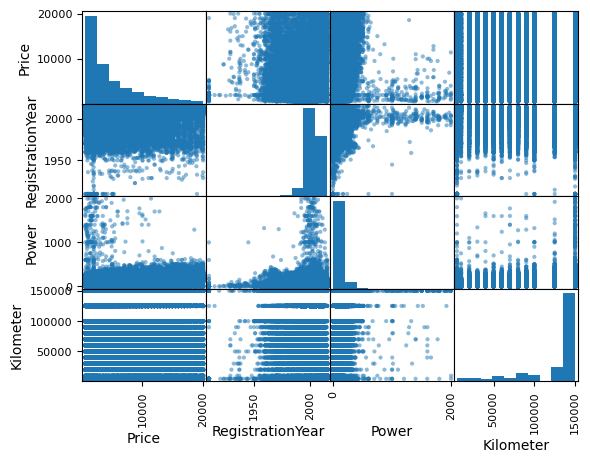

In [ ]:
plt.figure(figsize=(9,9))
pd.plotting.scatter_matrix(df)

plt.show()

Оценим корреляционную связь между признаками. вычислим коэффициенты парной корреляции, построим тепловую карту.

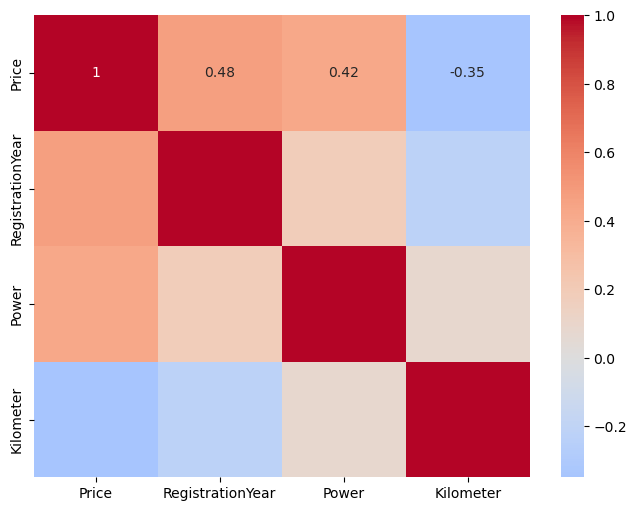

In [ ]:
num_col = ['Price', 'RegistrationYear', 'Power','Kilometer']
corr =df[num_col].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True,cmap='coolwarm',center=0)

plt.show()

Видим, что тесной линейной связи между ценой автомобиля и количественными факторами не наблюдается. Наибольшая положительная корреляция между ценой и мощностью двигателя, а также между ценой и годом регистрации составляет 0,41.

Среди признаков есть категориальные. Поэтому для построения моделей регрессии введем фиктивные переменные. Т.к. среди моделей автомобилей присутствует большое количество различных категорий, то при использовании прямого кодирования методом `OHE` получится разреженная матрица. Для таких матриц обучение моделей, построенных на решающих деревьях является не лучшим исходом. Поэтому применим для кодирования столбца `Model` класс `LabelEncoder()`.

Для удобства подготовки данных напишем функцию, которая выполнит разделение выборки на обучающую и тестовую, а также применим прямое кодирование к остальным категориальным переменным.

Разобьем выборку на обучающую и тестовую в соотношении 4:1, т.е. 80:20. Выборку для валидации выделять не будем, т.к. для подбора гиперпараметров моделей рассмотрим процедуру кросс-валидации.

In [ ]:
def prepare_data(df, target_name, scaler):
    # делим датасет на выборки

    X = df.drop(columns=target_name)
    y = df[target_name]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)

    # создайте списки с количественными и категориальными признаками
    cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
    num_col_names = X_train.select_dtypes(include='number').columns.tolist()

    if scaler == 'OHE':
      # выберите класс OneHotEncoder() для кодирования
      # задайте sparse значение False, избегайте дамми-ловушки
      ohe = OneHotEncoder(sparse=False, drop='first')

    # обучите и преобразуйте категориальные признаки из тренировочной и тестовой выборок
    # для тренировочной выборки выполните действия одной командой
      X_train_ohe = ohe.fit_transform(X_train[cat_col_names])
      X_test_ohe = ohe.transform(X_test[cat_col_names])

    # сохраняем в переменной encoder_col_names список названий новых столбцов
      encoder_col_names = ohe.get_feature_names_out()

    # создаём датафрейм из закодированных данных
    # передаём названия столбцов из переменной encoder_col_names
      X_train_cat = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
      X_test_cat = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    else:
      # выберите класс OrdinalEncoder() для кодирования

      ord = OrdinalEncoder()

     # обучите и преобразуйте категориальные признаки из тренировочной и тестовой выборок
      # для тренировочной выборки выполните действия одной командой
      X_train_ord = ord.fit_transform(X_train[cat_col_names])
      X_test_ord = ord.transform(X_test[cat_col_names])


      # создаём датафрейм из закодированных данных
      # передаём названия столбцов из переменной encoder_col_names
      X_train_cat = pd.DataFrame(X_train_ord, columns=X_train[cat_col_names].columns)
      X_test_cat = pd.DataFrame(X_test_ord, columns=X_train[cat_col_names].columns)

    # обнуляем индексы строк перед объединением количественных и категориальных
    # признаков в датафрейм
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()

    # объедините количественные и категориальные признаки для тренировочного
    # и тестового датасетов
    X_train = pd.concat([X_train_cat, X_train[num_col_names]], axis=1)
    X_test = pd.concat([X_test_cat, X_test[num_col_names]], axis=1)

    return X_train, X_test, y_train, y_test


In [ ]:
X_train_ohe, X_test_ohe, y_train, y_test = prepare_data(df, 'Price', 'OHE')

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(df, 'Price', None)

## Обучение моделей

### Кросс-валидация

* параметры модели настраиваются в процессе обучения модели на данных. Например, веса в линейной регрессии, нейросетях, структура решающего дерева;
* гиперпараметры — это характеристики модели, которые фиксируются до начала обучения: глубина решающего дерева, значение силы регуляризации в линейной модели, `learning rate` для градиентного спуска

Для подбора гиперпараметров моделей будем проводить кросс-валидацию. Кросс-валидация может быть нужна в случаях, если данных мало или мы не хотим зависеть от конкретного выбора валидационного множества.

Примерный алгоритм:
* зафиксировать некоторое тестовое множество и отложить его;  
* разделить оставшееся множество данных на фолдов (подмножеств), пройтись по ним циклом, на каждой итерации фиксируя один фолд в качестве валидационного и обучаясь на остальных;
* в качестве оценки качества модели взять среднее значение валидационной метрики по фолдам;
* финальное сравнение моделей с уже подобранными гиперпараметрами проводить на отложенном тестовом множестве.

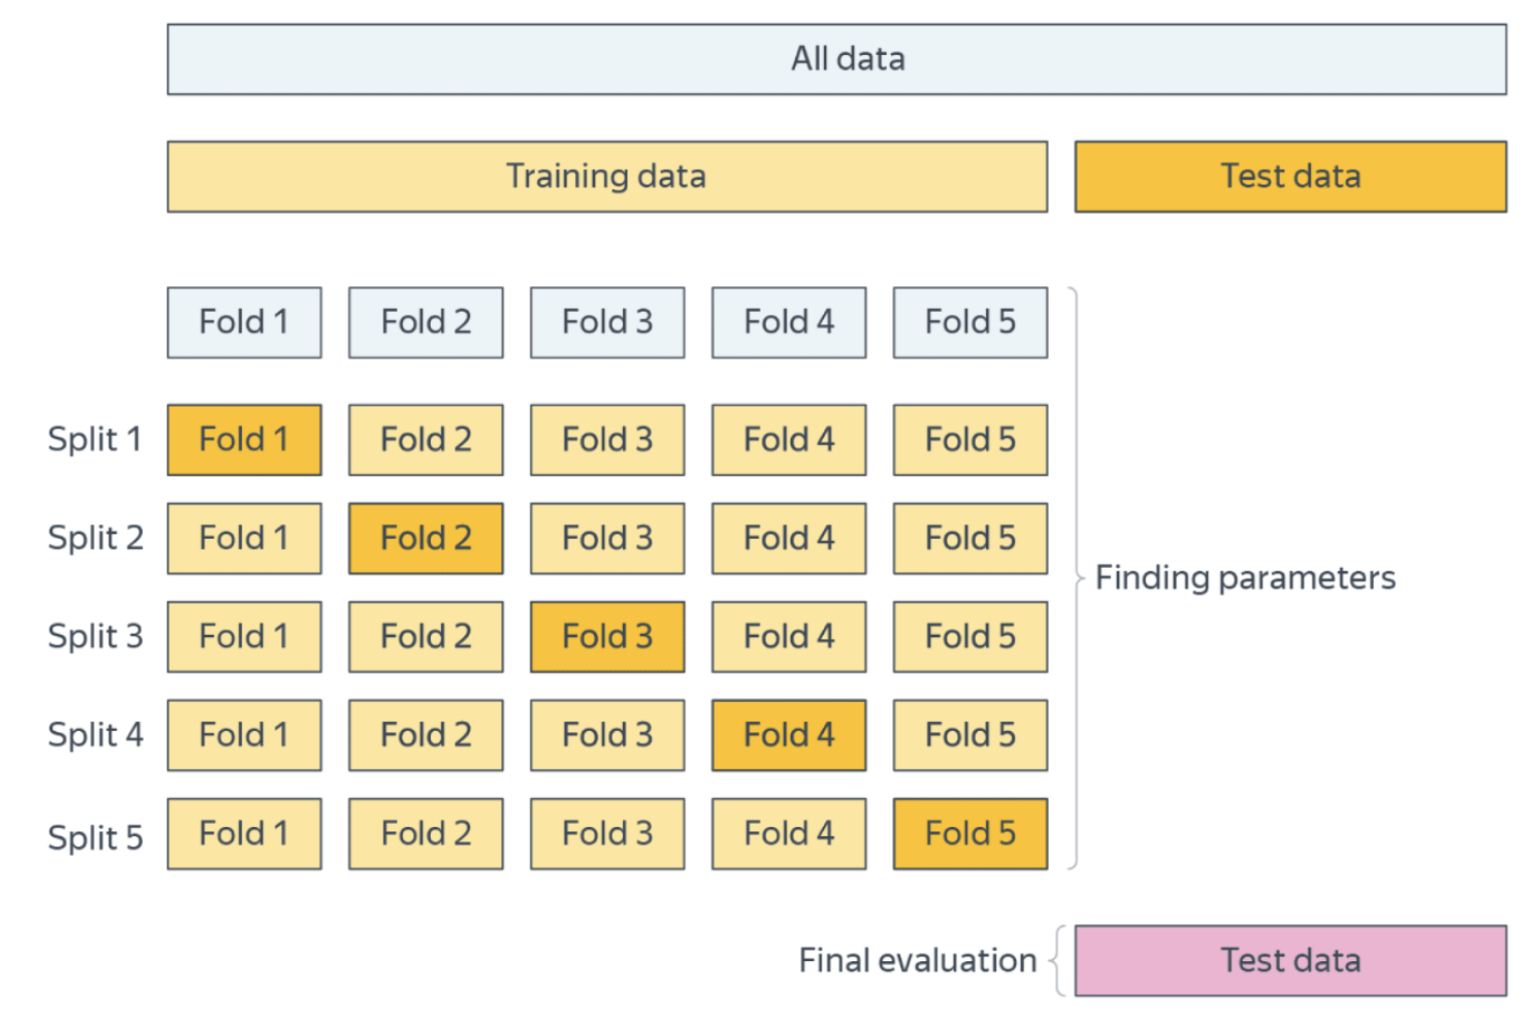

Самый естественный способ организовать перебор наборов гиперпараметров — сделать перебор по сетке (`Grid Search`):

* для каждого гиперпараметра фиксируется несколько значений;
* перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
* выбирается комбинация, на которой модель показывает лучшее качество.

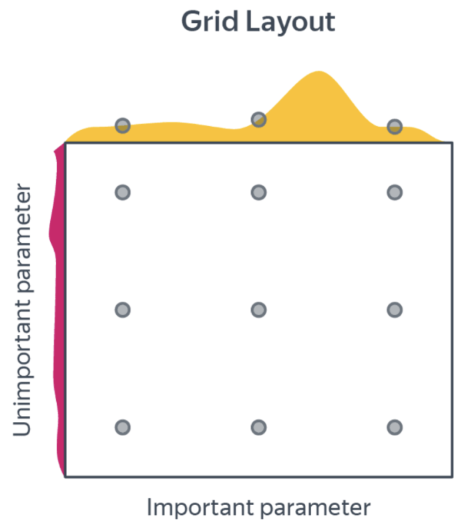

Подбирать гиперпараметры с помощью циклов не самый эффективный способ. Во-первых, это долго: понадобится перебрать все комбинации настроек. Во-вторых, сложно: придётся написать много кода, который, к тому же, трудно читать.

Инструмент для автоматизированного поиска гиперпараметров — `GridSearchCV` в `sklearn` - создаёт отдельную модель для каждой комбинации настроек, обучает её и считает метрику при кросс-валидации. Пользоваться таким инструментом удобно: он быстрее циклов и требует меньше кода.

Класс `GridSearchCV` выглядит следующим образом:

`GridSearchCV(
  estimator,
  param_grid,
  scoring=None,
  n_jobs=None,
  cv=None
) `

Параметры класса:
* `estimator` (обязательный) — инициализированная модель.
* `param_grid` (обязательный) — словарь со значениями гиперпараметров. Ключи — названия гиперпараметров, а по ключам хранятся списки значений гиперпараметров.
* `scoring` — метрика, которая будет считаться на обученных моделях.
* `n_jobs` — количество вычислительных мощностей. Чтобы считалось быстрее, указывают -1.
* `cv` — тип кросс-валидации.

Чтобы запустить поиск лучших значений гиперпараметров, нужно вызвать метод `fit()`:

инициализируем класс для поиска гиперпараметров

`gs = GridSearchCV(
    model,
    parameters
)`

запускаем поиск лучших гиперпараметров

`gs.fit(X_train, y_train)`

Когда поиск выполнится, код выведет лучшие значения гиперпараметров с помощью атрибута класса `GridSearchCV` — `gs.best_params_`

Что ещё вам может пригодиться:
* `best_estimator_ ` — лучшая обученная модель;
* `best_score_` — лучшая метрика при кросс-валидации;
* `cv_results_` — общие результаты поиска гиперпараметров.

### LinearRegression

Инициируем класс линейной регрессии `LinearRegression()`, обучим модель и вычислим метрику качества `RMSE`. Используем процедуру кросс-валидации

In [ ]:
start = time.time()
lr=LinearRegression().fit(X_train,y_train)

rmse_LR = np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))

end = time.time() - start
print('RMSE на валидационной выборке', rmse_LR)

RMSE на валидационной выборке 3135.1934717128256


### Decision Tree

In [ ]:
# инициализируем модель дерева решений
model = DecisionTreeRegressor(random_state=12345)


# Создайте словарь с гиперпараметрами:
# - min_samples_split в диапазоне от 2 до 6 (не включительно);
# - min_samples_leaf в диапазоне от 1 до 6 (не включительно);
# - max_depth в диапазоне от 2 до 10 (не включительно).
parameters = {'min_samples_split': range(2,6),
             'min_samples_leaf': range(1,6),
          'max_depth':range(2,10)
}

# Инициализируйте класс для автоматизированного поиска:
# значение кросс-валидации 5, метрика neg_root_mean_squared_error и n_jobs=-1.
dt = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=5,n_jobs=-1 # то ли я запихнула в скоринг

)

# запустите поиск гиперпараметров
dt.fit(X_train,y_train)

# выведите лучшие гиперпараметры
print('Гиперпараметры', dt.best_params_)




Гиперпараметры {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [ ]:
# выведите лучшую метрику качества
rmse_dt = np.sqrt(mean_squared_error(y_test, dt.best_estimator_.predict(X_test)))
print('RMSE', rmse_dt)

RMSE 2030.77793469821


Чтобы визуализировать построенное дерево, понадобится функция `plot_tree` из модуля `sklearn.tree`.

Функции нужно передать обученную модель с помощью параметра `decision_tree`. В конце строки указывают точку с запятой, чтобы вместе с графиком не выводился лишний текст. С помощью параметра `feature_names` отражаем наименование признаков в правилах.  Схему можно сделать цветной, указав аргумент `filled=True`

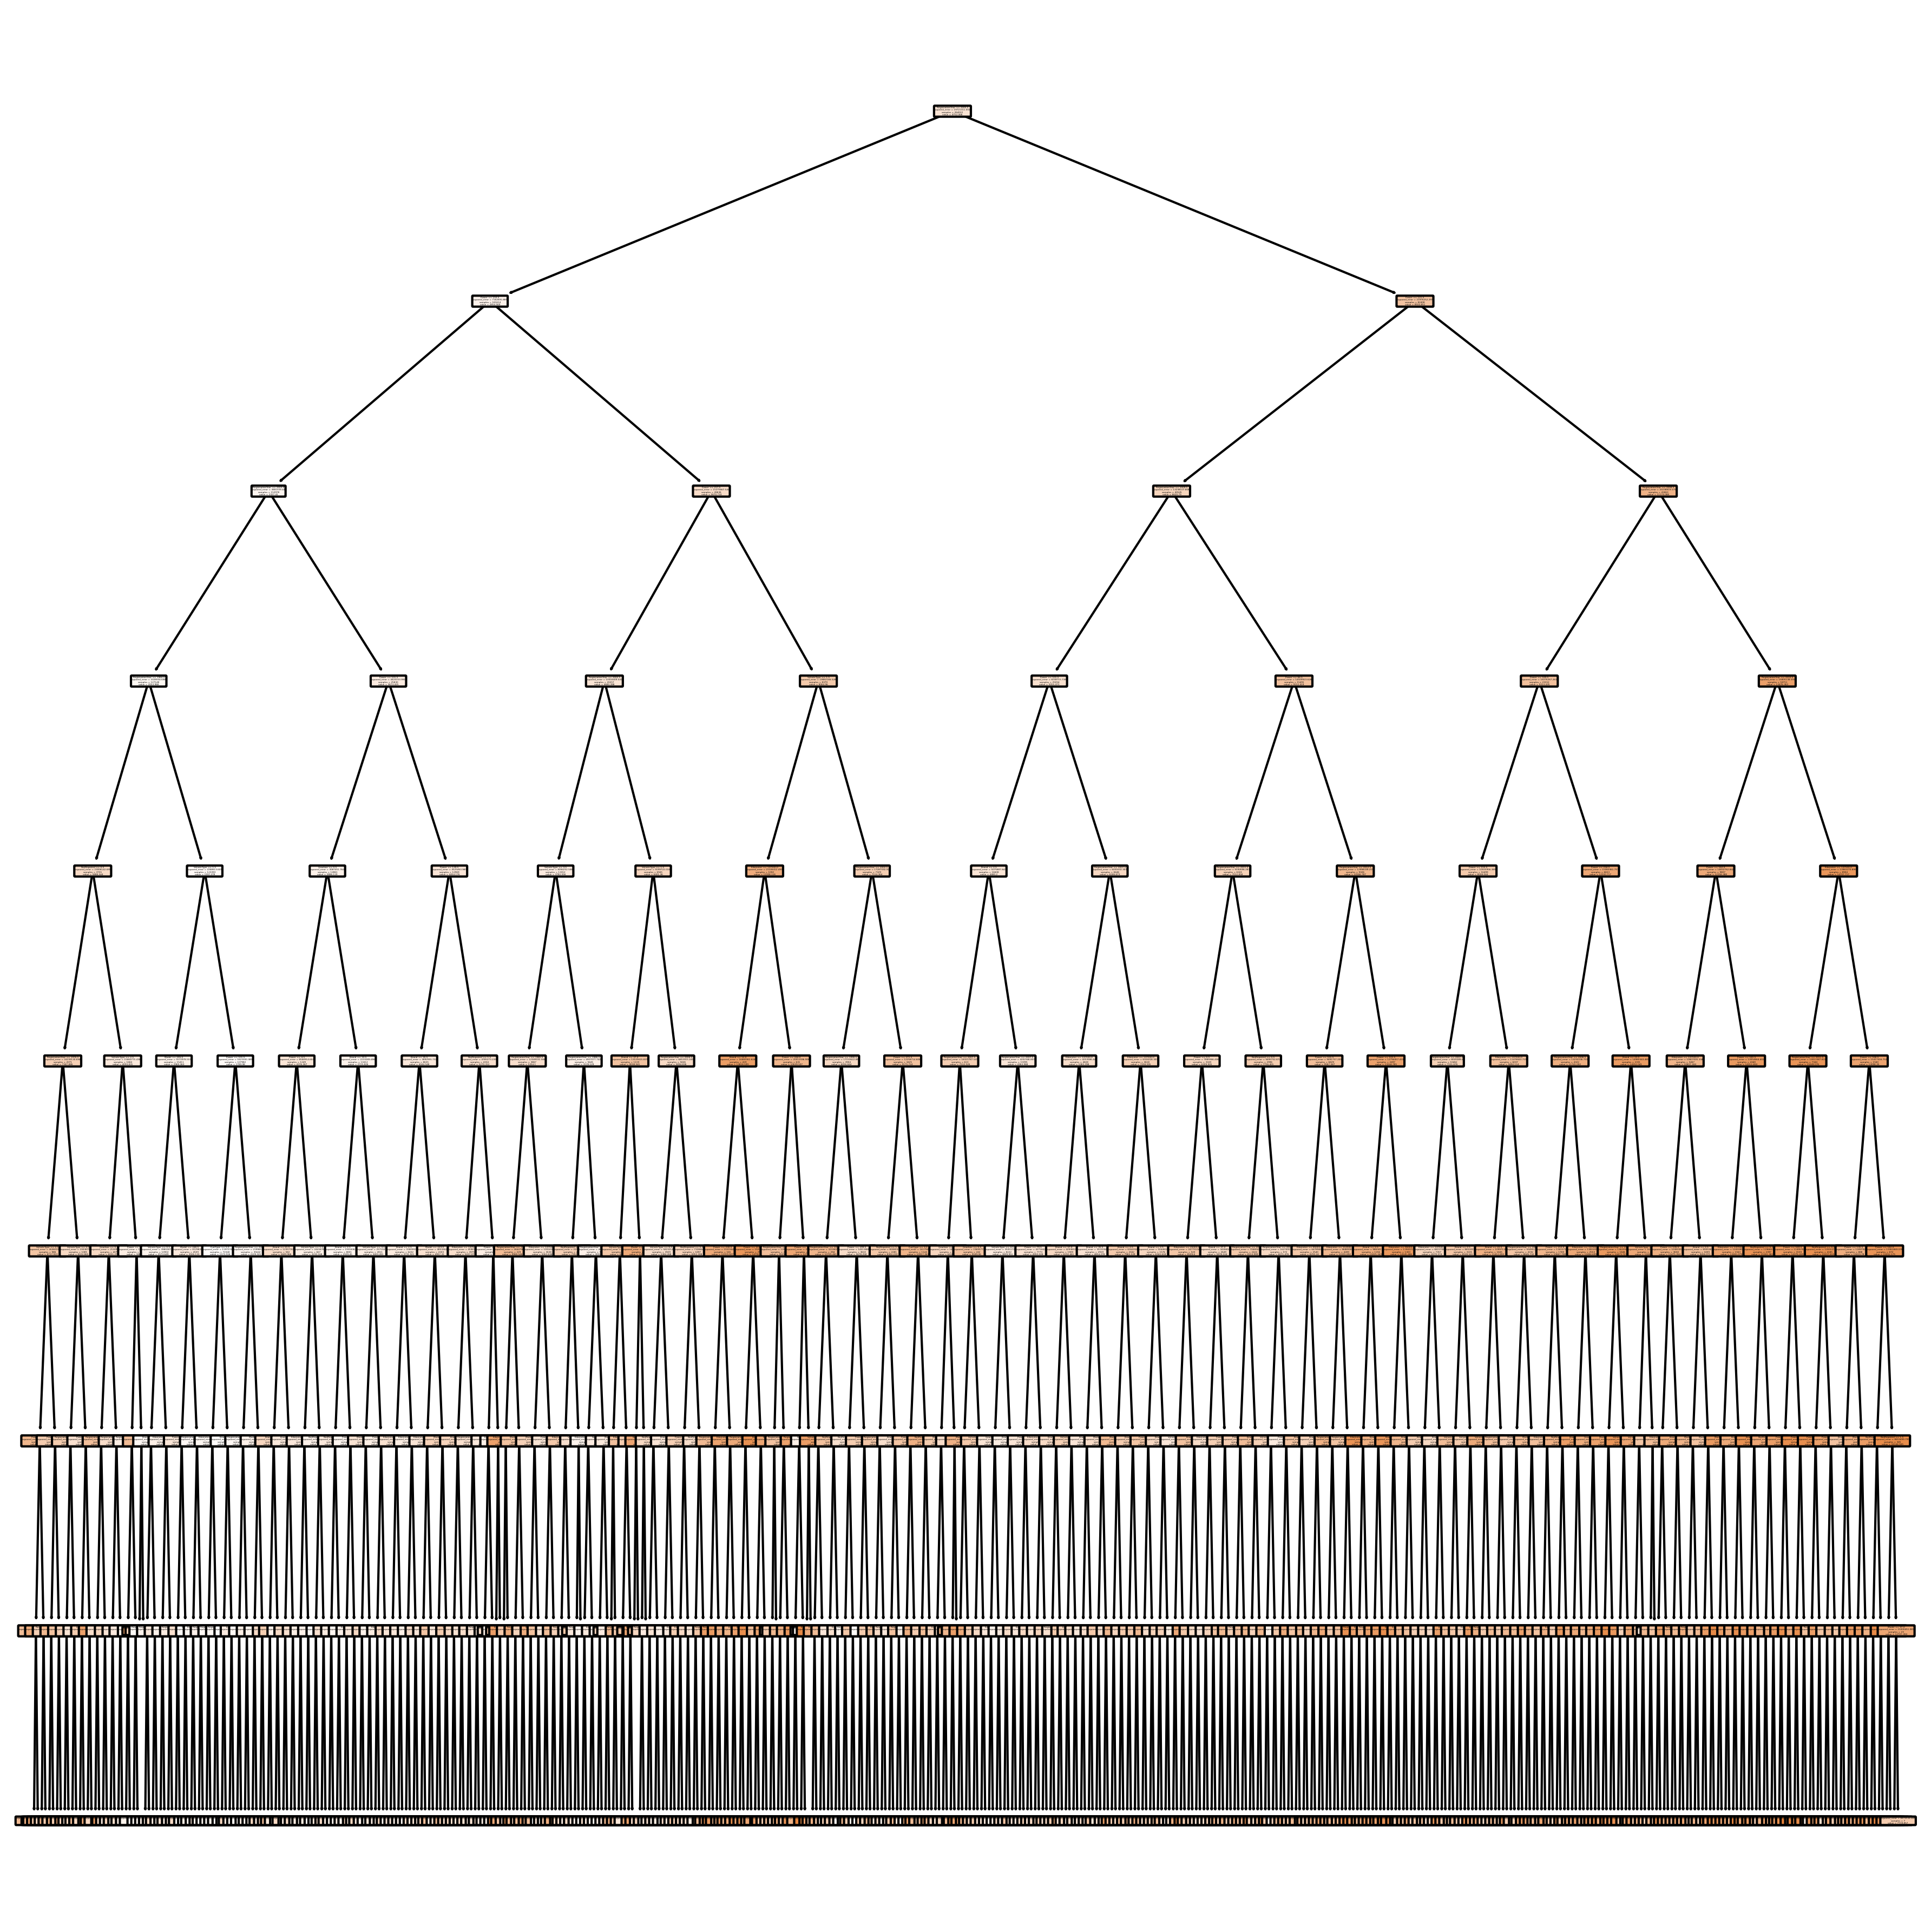

In [ ]:
# Построим решающее дерево, обученное на тренировочном наборе
# Построим решающее дерево, обученное на тренировочном наборе
plt.figure(figsize=(12, 12), dpi=300)

tree.plot_tree(decision_tree=dt.best_estimator_, feature_names=X_train.columns, filled=True,rounded=True);
plt.tight_layout()


In [ ]:
# Важность признаков
# Важность признаков оценим с помощью feature_importances_
feature_imp = pd.DataFrame(
     {'Признак' : X_train.columns,
        'Важность':dt.best_estimator_.feature_importances_
     }).sort_values(by ='Важность',  ascending = False)
feature_imp

,Признак,Важность
6,RegistrationYear,0.658196
7,Power,0.263043
0,VehicleType,0.022200
4,Brand,0.017938
8,Kilometer,0.016552
2,Model,0.009212
5,NotRepaired,0.008393
1,Gearbox,0.002418
3,FuelType,0.002048


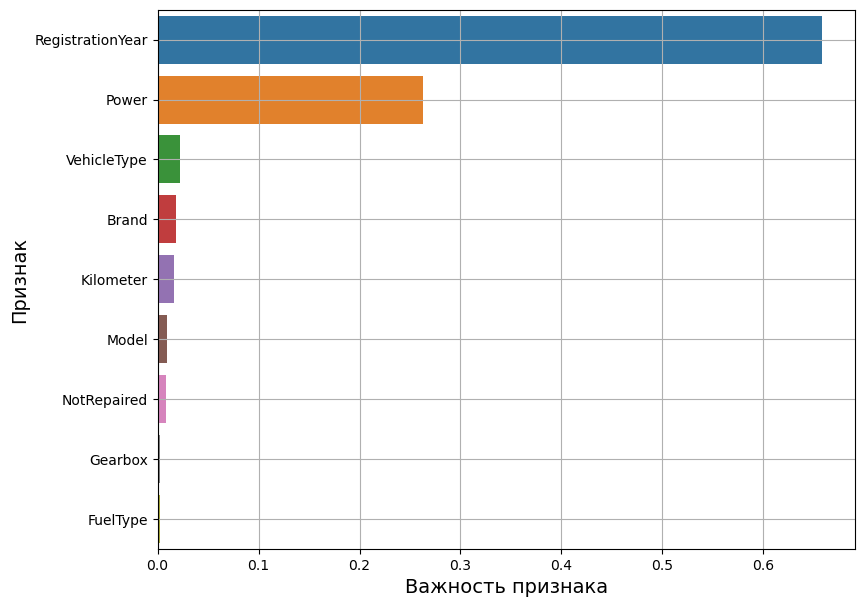

In [ ]:
# Визуализируем важность признаков
# добавляем размер графика
plt.figure(figsize=(9, 7))
sns.barplot(x=feature_imp['Важность'],y=feature_imp['Признак'])

plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

Оценка `permutation_importance` реализована в модуле `sklearn.inspection`.

Чтобы проверить важность признаков после перестановки, нужно передать функции обученную модель, тестовые данные и метрику, которой вы хотите оценить качество модели.

In [ ]:
permutation =permutation_importance(dt.best_estimator_, X_test, y_test, scoring='r2')

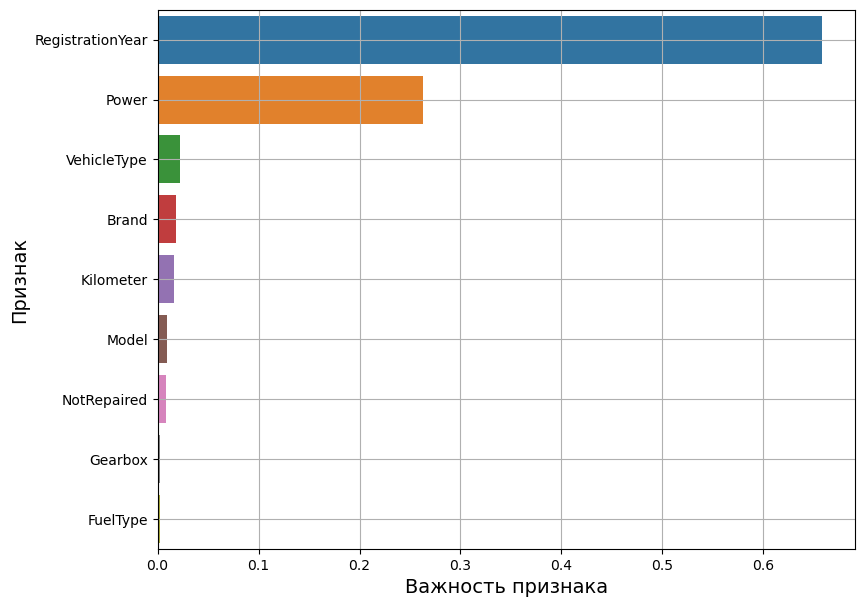

In [ ]:
# Сформируем датафрейм на основе важностей признаков после перестановки
feature_importance = pd.DataFrame({'Признак':X_train.columns,
                                   'Важность':dt.best_estimator_.feature_importances_ }).sort_values('Важность', ascending=False)


# Визуализируем результат в виде столбиковой диаграммы

plt.figure(figsize=(9, 7))
sns.barplot(y=feature_importance['Признак'],x=feature_importance['Важность'])

plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

Перемешивание значений не выявило других фаворитов.

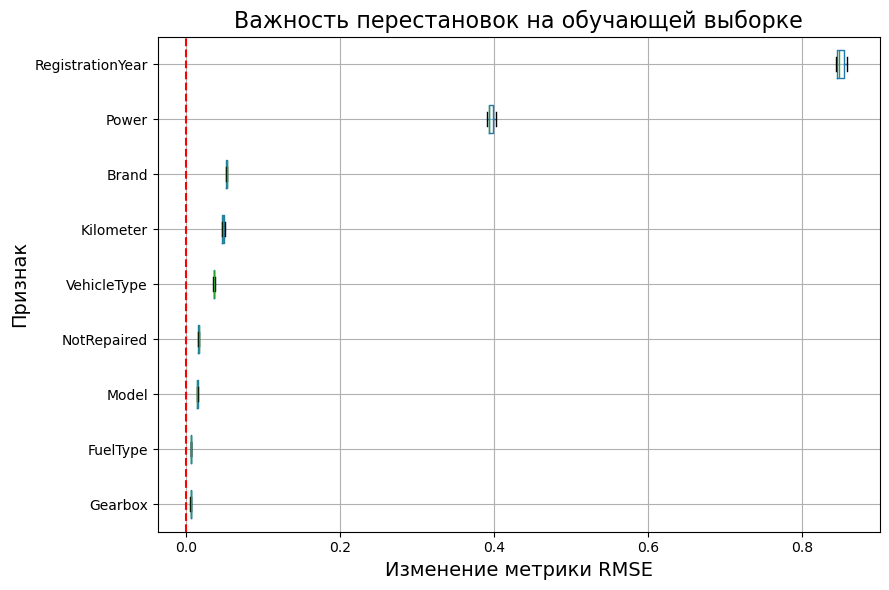

In [ ]:
sorted_importances = permutation.importances_mean.argsort()
importances = pd.DataFrame(
    permutation.importances[sorted_importances].T,
    columns=X_train.columns[sorted_importances],
)

plt.figure(figsize=(9, 6))

ax = importances.boxplot(vert=False, whis=5)
ax.axvline(x=0, color="red", linestyle="--")

plt.xlabel('Изменение метрики RMSE', fontsize = 14)
plt.ylabel('Признак', fontsize = 14)
plt.title('Важность перестановок на обучающей выборке', fontsize = 16)
plt.tight_layout()
plt.show()


Видим, что на изменение метрики `RMSE` больше всего влияет год регистрации автомобиля, мощность двигателя, пробег, тип кузова и бренд.


Используем методы фильтрации для отбора наиболее информативных признаков. От лишних признаков стоит избавиться с помощью `SelectKBest`. Дерево решений не ищет линейные зависимости, поэтому выбираем метод `mutual_info_classif`

In [ ]:
selector = SelectKBest(mutual_info_regression, k=4).fit(X_train, y_train)
features_names = selector.get_feature_names_out()


In [ ]:
features_names

array(['NotRepaired', 'RegistrationYear', 'Power', 'Kilometer'],
      dtype=object)

### LGBM_Regressor

In [ ]:
# инициализируем модель LGBM
model =LGBMRegressor(random_state=12345)

# Создайте словарь с гиперпараметрами:
# - max_depth в диапазоне от 5 до 10 (включительно);
# - n_estimators: [250, 300, 350, 400, 450];
# - learning_rate : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
parameters = {'max_depth':range(5,10),
              'n_estimators': [250, 300, 350, 400, 450],
              'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

}


# Инициализируйте класс для автоматизированного поиска:
# значение кросс-валидации cvs, метрика neg_root_mean_squared_error и n_jobs=-1.
lgbm = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error',  cv=5, n_jobs=-1)


# запустите поиск гиперпараметров
lgbm.fit(X_train,y_train)
# выведите лучшие гиперпараметры
print('Гиперпараметры', lgbm.best_params_ )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 264022, number of used features: 9
[LightGBM] [Info] Start training from score 4752.067934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Гиперпараметры {'learning_rate':

In [ ]:
# выведите лучшую метрику качества
rmse_lgbm = np.sqrt(mean_squared_error(y_test,lgbm.best_estimator_.predict(X_test)))
print('RMSE', rmse_lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE 1561.261934721001


In [ ]:
# Важность признаков
# Важность признаков оценим с помощью feature_importances_
feature_imp = pd.DataFrame(
     {'Признак' :X_train.columns,
        'Важность':lgbm.best_estimator_.feature_importances_
     }).sort_values(by ='Важность',  ascending = False)
feature_imp

,Признак,Важность
6,RegistrationYear,3071
7,Power,3068
2,Model,2084
4,Brand,1486
8,Kilometer,1407
0,VehicleType,1117
5,NotRepaired,501
3,FuelType,392
1,Gearbox,341


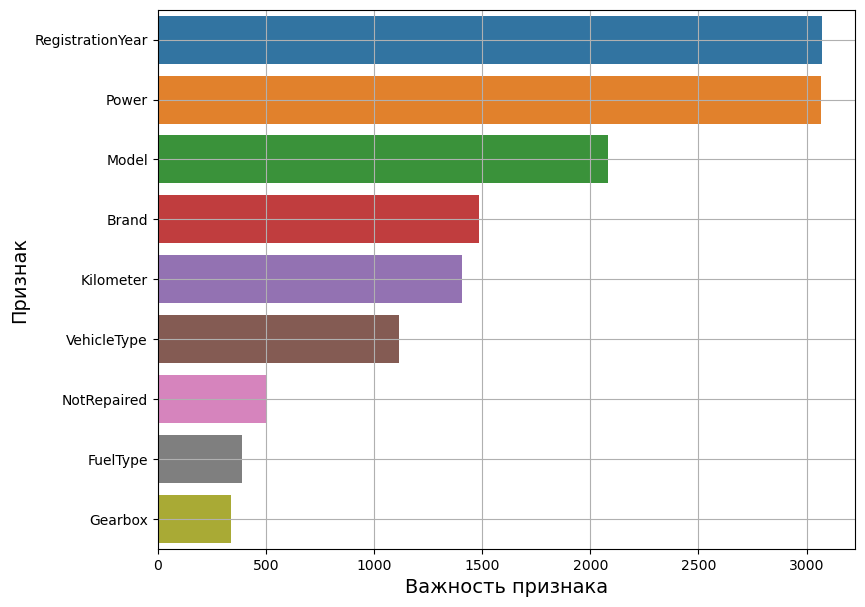

In [ ]:
# Визуализируем важность признаков
# добавляем размер графика
plt.figure(figsize=(9, 7))

sns.barplot(x=feature_imp['Важность'],y=feature_imp['Признак'])
plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

### CatBoostRegressor

In [ ]:
# инициализируем модель CatBoostRegressor, зададим число итераций не менее 1000
model=CatBoostRegressor(random_state=12345)
# Создайте словарь с гиперпараметрами:
# - depth в диапазоне от 5 до 10 (включительно);
# - learning_rate : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

parameters = {'depth':range(5,10),
              'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]

}


# Инициализируйте класс для автоматизированного поиска:
# значение кросс-валидации cvs, метрика neg_root_mean_squared_error и n_jobs=-1.
cat = GridSearchCV(model, parameters, scoring='neg_root_mean_squared_error', cv=5,n_jobs=-1)


# запустите поиск гиперпараметров

cat.fit(X_train,y_train)
# выведите лучшие гиперпараметры
print('Гиперпараметры', cat.best_params_)

0:	learn: 3832.9438827	total: 161ms	remaining: 2m 40s
1:	learn: 3364.0659320	total: 186ms	remaining: 1m 33s
2:	learn: 3016.1312129	total: 211ms	remaining: 1m 9s
3:	learn: 2756.5149895	total: 235ms	remaining: 58.4s
4:	learn: 2549.9389586	total: 258ms	remaining: 51.3s
5:	learn: 2399.4036419	total: 281ms	remaining: 46.5s
6:	learn: 2286.1030230	total: 304ms	remaining: 43.1s
7:	learn: 2197.6376073	total: 328ms	remaining: 40.7s
8:	learn: 2130.8937028	total: 351ms	remaining: 38.7s
9:	learn: 2078.5306349	total: 374ms	remaining: 37s
10:	learn: 2035.8784892	total: 399ms	remaining: 35.9s
11:	learn: 2001.6993694	total: 426ms	remaining: 35.1s
12:	learn: 1975.9987248	total: 451ms	remaining: 34.3s
13:	learn: 1952.9453067	total: 477ms	remaining: 33.6s
14:	learn: 1928.6776884	total: 501ms	remaining: 32.9s
15:	learn: 1906.6275975	total: 526ms	remaining: 32.3s
16:	learn: 1893.1106582	total: 565ms	remaining: 32.7s
17:	learn: 1882.3158727	total: 590ms	remaining: 32.2s
18:	learn: 1864.7308788	total: 619ms	r

In [ ]:
# выведите лучшую метрику качества
rmse_cat = np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))
print('RMSE', rmse_cat)

RMSE 1541.5013099789535


## Анализ моделей

In [ ]:
# Сформируем по результатам обучения итоговую таблицу
Results = pd.DataFrame({'Model' : ['Линейная регрессия', 'Дерево решений', 'Легкий градиентный бустинг (LGBM)',
                                  'Категориальный бустинг (CatBoost)'],
                        'RMSE на валидационной выборке' : [rmse_LR, rmse_dt,
                                                           rmse_lgbm, rmse_cat],
                       'Время обучения': [end,
                                         dt.cv_results_["mean_fit_time"][dt.best_index_],

                                         lgbm.cv_results_["mean_fit_time"][lgbm.best_index_],
                                         cat.cv_results_["mean_fit_time"][cat.best_index_]]
                        })

Results

,Model,RMSE на валидационной выборке,Время обучения
0,Линейная регрессия,3135.193472,0.133643
1,Дерево решений,2030.777935,1.467813
2,Легкий градиентный бустинг (LGBM),1561.261935,10.693844
3,Категориальный бустинг (CatBoost),1541.501310,171.017565


Видим, что для модели линейной регрессии метрика RMSE на валидационной выборке превышает минимально допустимое значение. Для всех других рассмотренных моделей метрика RMSE < 2500. Наилучший результат качества обучения имеет алгоритм CatBoost, но обучение длилось немного дольше, чем для LGBM Regressor. На основании полученных результатов, делаем вывод, что наиболее оптимальной моделью среди рассмотренных моделей регрессии является модель LGBMResgressor


### Проверка на тестовом наборе

In [ ]:
best_model = LGBMRegressor(learning_rate=0.25,
                           max_depth=9,
                           n_estimators=450,
                           random_state=12345,
                           force_col_wise=True,
                           verbose=-1).fit(X_train, y_train)

In [ ]:
%%time
model_pred =best_model.predict(X_test)


CPU times: total: 1.59 s
Wall time: 272 ms


In [ ]:
# Вычислим основные метрики регрессии на тестовом множестве
print("R2 на тестовой выборке:", r2_score(y_test,model_pred))
print("MAE на тестовой выборке:", mean_absolute_error(y_test,model_pred))
print("MAPE на тестовой выборке:", mean_absolute_percentage_error(y_test,model_pred))
print("MSE на тестовой выборке:", mean_squared_error(y_test,model_pred))
print("RMSE на тестовой выборке:", np.sqrt(mean_squared_error(y_test,model_pred)))# точно ли так????

R2 на тестовой выборке: 0.8742714530244796
MAE на тестовой выборке: 985.4031740823384
MAPE на тестовой выборке: 0.33544365905448004
MSE на тестовой выборке: 2437538.8288087626
RMSE на тестовой выборке: 1561.261934721001


На тестовом наборе время прогнозирования составило 272 ms, метрика `RMSE` = 1561.26

### Проверка модели на адекватность. Оценка константной моделью

In [ ]:
DummyModel=DummyRegressor().fit(X_train,y_train)
rmse_dummy =np.sqrt(mean_squared_error(y_test,DummyModel.predict(X_test)))

In [ ]:
print('Константная модель:')
print('rmse', rmse_dummy)


Константная модель:
rmse 4403.242937390249


In [ ]:
r2_dummy =r2_score(y_test,DummyModel.predict(X_test))
print('Константная модель:')
print('R2', r2_dummy)


Константная модель:
R2 -6.366469759777615e-05


Значение метрики RMSE для константной модели на тестовой выборке составило 4403,24, коэффициент детерминации отрицательный и близок к нулю. Таким образом, построенную модель регрессии можем считать адекватной.

## Отбор признаков с использованием MLxtend

In [ ]:
sfs = SFS(best_model, k_features=6, forward=True, floating=False, scoring='neg_root_mean_squared_error', cv=5)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LGBMRegressor(force_col_wise=True,
                                                  learning_rate=0.25,
                                                  max_depth=9, n_estimators=450,
                                                  random_state=12345,
                                                  verbose=-1),
                          k_features=(6, 6),
                          scoring='neg_root_mean_squared_error')

In [ ]:
# названия признаков
sfs.k_feature_names_

('VehicleType',
 'Model',
 'NotRepaired',
 'RegistrationYear',
 'Power',
 'Kilometer')

In [ ]:
# метрика оценки качества
-sfs.k_score_

1642.3562085957442

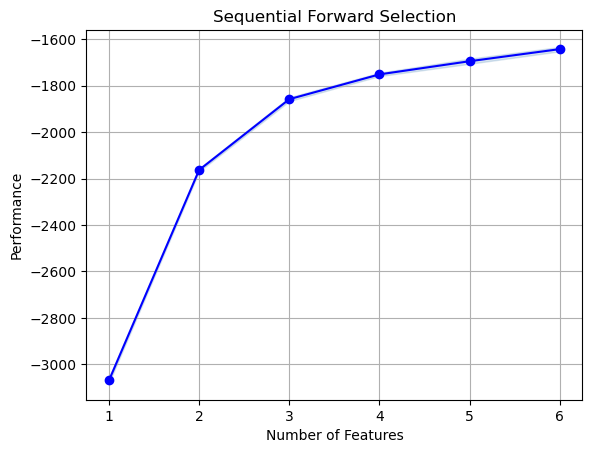

In [ ]:
fig1 = plot_sequential_feature_selection(sfs.get_metric_dict(confidence_interval=0.9), kind='std_dev')
plt.grid()
plt.title('Sequential Forward Selection')
plt.show()

In [ ]:
X_train_sfs = X_train[list(sfs.k_feature_names_)]
X_test_sfs = X_test[list(sfs.k_feature_names_)]
model = LGBMRegressor(learning_rate=0.25,
                           max_depth=9,
                           n_estimators=450,
                           random_state=12345,
                           force_col_wise=True,
                           verbose=-1).fit(X_train_sfs, y_train)

NameError: name 'X_train' is not defined

In [ ]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test_sfs)

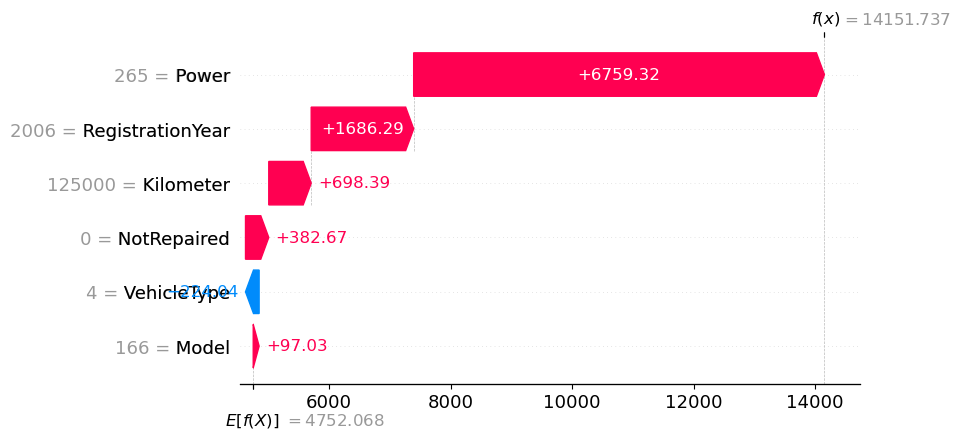

In [ ]:
shap.plots.waterfall(shap_values[0])

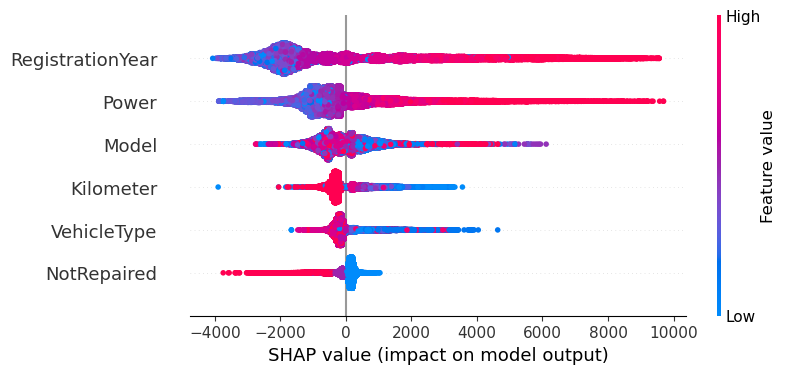

In [ ]:
shap.plots.beeswarm(shap_values)